In [1]:
import numpy as np
import vorostereology as vs
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d as m3
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from scipy.spatial import Voronoi, voronoi_plot_2d
import voroplusplus as vpp
import pyvoro
from scipy import ndimage
import pandas as pd
import csv
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern

((3, 3592), (3, 1020))

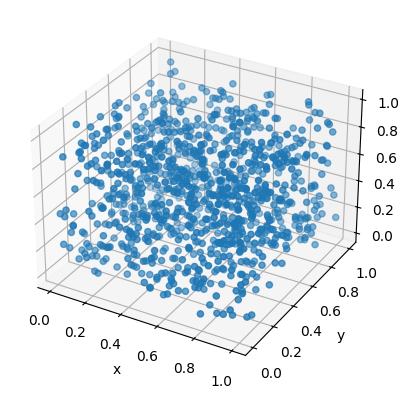

In [145]:
# ######################################## Define/ initialize points##############################################
xMin = 0;
xMax = 1;
yMin = 0;
yMax = 1;
zMin = 0;
zMax = 1;

domain = [[xMin, xMax], [yMin, yMax], [zMin, zMax]]

#Parameters for the parent and daughter point processes
# lambdaPoisson=2000;#density of underlying Poisson point process
radiusCore=0.017;#radius of hard core

#Extended simulation windows parameters
rExt=radiusCore; #extension parameter -- use core radius
xMinExt=xMin-rExt;
xMaxExt=xMax+rExt;
yMinExt=yMin-rExt;
yMaxExt=yMax+rExt;
zMinExt=zMin-rExt;
zMaxExt=zMax+rExt;
#rectangle dimensions
xDeltaExt=xMaxExt-xMinExt;
yDeltaExt=yMaxExt-yMinExt;
zDeltaExt=zMaxExt-zMinExt;
volumeTotalExt=xDeltaExt*yDeltaExt*zDeltaExt; #volume of extended rectangle

#Simulate Poisson point process for the parents
# numbPointsExt= np.random.poisson(volumeTotalExt*lambdaPoisson);#Poisson number
numbPointsExt = 4000
#x and y and z coordinates of Poisson points for the parent
xxPoissonExt=xMinExt+xDeltaExt*np.random.rand(numbPointsExt);
yyPoissonExt=yMinExt+yDeltaExt*np.random.rand(numbPointsExt);
zzPoissonExt=zMinExt+zDeltaExt*np.random.rand(numbPointsExt);
    
#thin points if outside the simulation window
booleWindow=((xxPoissonExt>=xMin)&(xxPoissonExt<=xMax)&(yyPoissonExt>=yMin)&(yyPoissonExt<=yMax)&(zzPoissonExt>=zMin)&(zzPoissonExt<=zMax));
indexWindow=np.arange(numbPointsExt)[booleWindow];
#retain points inside simulation window
xxPoisson=xxPoissonExt[booleWindow];
yyPoisson=yyPoissonExt[booleWindow];
zzPoisson=zzPoissonExt[booleWindow];
    
numbPoints=len(xxPoisson); #number of Poisson points in window
#create random marks for ages
markAge=np.random.rand(numbPointsExt);
    
###START Removing/thinning points START###
booleRemoveI=np.zeros(numbPoints, dtype=bool);#Index for removing points -- Matern I
booleKeepII=np.zeros(numbPoints,dtype=bool);#Index for keeping points -- Matern II
for ii in range(numbPoints):
    distTemp=np.hypot(xxPoisson[ii]-xxPoissonExt,yyPoisson[ii]-yyPoissonExt,zzPoisson[ii]-zzPoissonExt);  #distances to other points        
    booleInDisk=(distTemp<radiusCore)&(distTemp>0); #check if inside disk
        
        #Matern I
    booleRemoveI[ii]=any(booleInDisk);
        
        #Matern II
        #keep the younger points
    if len(markAge[booleInDisk])==0:
        booleKeepII[ii]=True;
            #Note: if markAge(booleInDisk) is empty, keepBooleII[ii]=True.
    else:
        booleKeepII[ii]=all(markAge[indexWindow[ii]]<markAge[booleInDisk]);
            
            
    ###END Removing/thinning points END###
    
    #Remove/keep points to generate Matern hard-core processes
    #Matérn I
booleKeepI=~(booleRemoveI);
xxMaternI=xxPoisson[booleKeepI];
yyMaternI=yyPoisson[booleKeepI];
zzMaternI=zzPoisson[booleKeepI];
    #Matérn II
xxMaternII=xxPoisson[booleKeepII];
yyMaternII=yyPoisson[booleKeepII];
zzMaternII=zzPoisson[booleKeepII];
# Plotting
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(xxMaternII,yyMaternII,zzMaternII);
# ax.scatter3D(xxMaternI,yyMaternI,zzMaternI);
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

s=np.array([xxMaternII.T,yyMaternII.T,zzMaternII.T])
# s=np.array([xxMaternI.T,yyMaternI.T,zzMaternI.T])
sp=np.array([xxPoisson.T,yyPoisson.T,zzPoisson.T])

sp.shape, s.shape

In [ ]:
3000*(2.7*(1.1**((radiusCore-0.01)/0.005)))

2.1224643700882167e+45

In [78]:
s=np.array([xxMaternII.T,yyMaternII.T,zzMaternII.T])
sp=np.array([xxPoisson.T,yyPoisson.T,zzPoisson.T])

s.shape

(3, 31)

In [ ]:
s.T[np.random.choice(np.array(range(s.shape[1])), size=500, replace=False)]

(500, 3)

In [5]:
#######Generate 3D Voronoi###########
pycells=pyvoro.compute_voronoi(
s.T, # point positions
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], # limits
1.0, # block size
# particle radii -- optional, and keyword-compatible arg.
)

In [6]:
#######Generate 3D Voronoi###########
pycells=pyvoro.compute_voronoi(
sp.T, # point positions
[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], # limits
10.0, # block size
[0.7]*len(xxPoisson),# particle radii -- optional, and keyword-compatible arg.
)

In [26]:
######Taking 9 cross-sections#####
coeffs = np.array([0.5, 0.0, 0.0])
r1=np.arange(0.3, 0.7, 0.05).tolist()
cross_section_tot=[vs.compute_cross_section(coeffs=coeffs, offset = np.array([0.25, 0.5, 1.0]), points = s.T, domain=domain, weights = np.zeros((s.T).shape[0]))]
for x in range(0,8):
 cross_section_tot += [vs.compute_cross_section(coeffs=coeffs, offset = np.array([r1[x], 0.5, 1.0]), points = s.T, domain=domain, weights = np.zeros((s.T).shape[0]))]
   

In [10]:
fig = plt.figure()
ax = Axes3D(fig)

for cell_idx, cell in enumerate(pycells):
    for facet_idx, facet in enumerate(cell['faces']):
        idx = np.array(facet['vertices'])
        polygon = m3.art3d.Poly3DCollection([np.array(cell['vertices'])[idx]])
        polygon.set_edgecolor('k')
        polygon.set_alpha(0.1)
        ax.add_collection3d(polygon)


for x in range(0, 9, 1):
    for cell in cross_section_tot[x]['3d']:
        polygon = m3.art3d.Poly3DCollection([cell])
        polygon.set_color("red")
        polygon.set_edgecolor('k')
        ax.add_collection3d(polygon)
    
ax.set_xlim3d(domain[0])
ax.set_ylim3d(domain[1])
ax.set_zlim3d(domain[2])
ax.set_box_aspect((1, 1, 1))
ax.set_axis_off()
plt.show(block=False)



<Figure size 640x480 with 0 Axes>

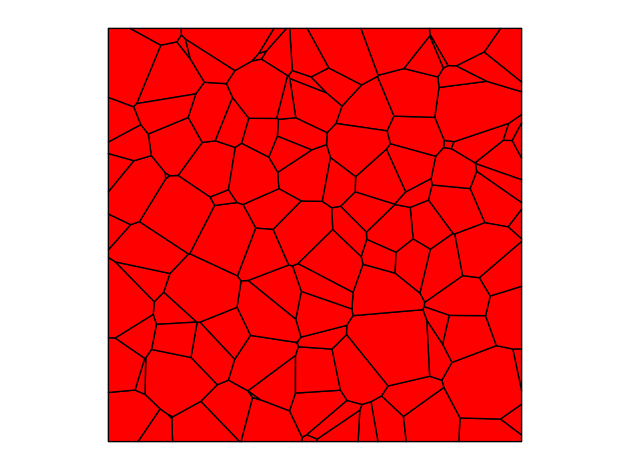

In [27]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

coll = PolyCollection(cross_section_tot[6]['2d'], facecolors="red", edgecolors='k')
ax2.add_collection(coll)
ax2.axis("equal")
ax2.set_axis_off()
fig2.tight_layout()
plt.show()





In [42]:
#####Taking the centroid of the visible grains in the cross-sections and create data-set#####
x = [p[0] for p in cross_section_tot[0]['2d'][0]]
y = [p[1] for p in cross_section_tot[0]['2d'][0]]
centroid0=[(sum(x) / len(cross_section_tot[0]['2d'][0]), sum(y) / len(cross_section_tot[0]['2d'][0]))]
for i in range(1,len(cross_section_tot[0]['2d'])):
     x = [p[0] for p in cross_section_tot[0]['2d'][i]]
     y = [p[1] for p in cross_section_tot[0]['2d'][i]]
     centroid0.append((sum(x) / len(cross_section_tot[0]['2d'][i]), sum(y) / len(cross_section_tot[0]['2d'][i])))
id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
df0=pd.DataFrame(centroid0,columns=['x','y'])
df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains], axis=1)
for j in range(1,8):
    x = [p[0] for p in cross_section_tot[j]['2d'][0]]
    y = [p[1] for p in cross_section_tot[j]['2d'][0]]
    centroidj=[(sum(x) / len(cross_section_tot[j]['2d'][0]), sum(y) / len(cross_section_tot[j]['2d'][0]))]
    for i in range(1,len(cross_section_tot[j]['2d'])):
        x = [p[0] for p in cross_section_tot[j]['2d'][i]]
        y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
        centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
    id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
    dfj=pd.DataFrame(centroidj,columns=['x','y'])
    dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains], axis=1)
    dfj_tot=pd.concat([df0,dfj])
    df0=dfj_tot   



In [ ]:
#####Taking the center of mass of the visible grains in the cross-sections and create data-set#####
center_mass0=[ndimage.measurements.center_of_mass(cross_section_tot[0]['2d'][0])]
for i in range(1,len(cross_section_tot[0]['2d'])):
 center_mass0.append(ndimage.measurements.center_of_mass(cross_section_tot[0]['2d'][i]))

id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
df0=pd.DataFrame(center_mass0,columns=['x','y'])
df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains], axis=1)
for x in range(1,8):
    center_massx=[ndimage.measurements.center_of_mass(cross_section_tot[x]['2d'][0])]
    for i in range(1,len(cross_section_tot[x]['2d'])):
     center_massx.append(ndimage.measurements.center_of_mass(cross_section_tot[x]['2d'][i]))
    id_sec=pd.DataFrame([(x+1)*0.1]*len(cross_section_tot[x]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[x]['original_indices'],columns=['id_grain'])
    dfx=pd.DataFrame(center_massx,columns=['x','y'])
    dfx=pd.concat([dfx.reset_index(drop=True), id_sec, id_grains], axis=1)
    dfx_tot=pd.concat([df0,dfx])
    df0=dfx_tot   

In [44]:
####Finalize dataset and export data####
id_vor=pd.DataFrame([1]*dfj_tot.shape[0],columns=['id_vor'])
dfj_tot=pd.concat([dfj_tot.reset_index(drop=True), id_vor], axis=1)

In [45]:
dfj_tot.to_csv('dftotcl1.csv')

In [4]:
#########Generazione multipla######
dfj_tot_tot=pd.DataFrame(columns=['x','y','id_sec','id_grain','g_area','id_vor'])
xMin = 0;
xMax = 1;
yMin = 0;
yMax = 1;
zMin = 0;
zMax = 1;

#Parameters for the parent and daughter point processes
lambdaPoisson=2000;#density of underlying Poisson point process
radiusCore=0.055;#radius of hard core


#Extended simulation windows parameters
rExt=radiusCore; #extension parameter -- use core radius
xMinExt=xMin-rExt;
xMaxExt=xMax+rExt;
yMinExt=yMin-rExt;
yMaxExt=yMax+rExt;
zMinExt=zMin-rExt;
zMaxExt=zMax+rExt;
#rectangle dimensions
xDeltaExt=xMaxExt-xMinExt;
yDeltaExt=yMaxExt-yMinExt;
zDeltaExt=zMaxExt-zMinExt;
volumeTotalExt=xDeltaExt*yDeltaExt*zDeltaExt; #volume of extended rectangle


for k in range(1,5001):
    numbPointsExt= np.random.poisson(volumeTotalExt*lambdaPoisson);#Poisson number
    xxPoissonExt=xMinExt+xDeltaExt*np.random.rand(numbPointsExt);
    yyPoissonExt=yMinExt+yDeltaExt*np.random.rand(numbPointsExt);
    zzPoissonExt=zMinExt+zDeltaExt*np.random.rand(numbPointsExt);
    booleWindow=((xxPoissonExt>=xMin)&(xxPoissonExt<=xMax)&(yyPoissonExt>=yMin)&(yyPoissonExt<=yMax)&(zzPoissonExt>=zMin)&(zzPoissonExt<=zMax));
    indexWindow=np.arange(numbPointsExt)[booleWindow];
    xxPoisson=xxPoissonExt[booleWindow];
    yyPoisson=yyPoissonExt[booleWindow];
    zzPoisson=zzPoissonExt[booleWindow];    
    numbPoints=len(xxPoisson); #number of Poisson points in window
    markAge=np.random.rand(numbPointsExt);
    booleRemoveI=np.zeros(numbPoints, dtype=bool);#Index for removing points -- Matern I
    booleKeepII=np.zeros(numbPoints,dtype=bool);#Index for keeping points -- Matern II
    for ii in range(numbPoints):
        distTemp=np.hypot(xxPoisson[ii]-xxPoissonExt,yyPoisson[ii]-yyPoissonExt,zzPoisson[ii]-zzPoissonExt);  #distances to other points        
        booleInDisk=(distTemp<radiusCore)&(distTemp>0); #check if inside disk
        if len(markAge[booleInDisk])==0:
            booleKeepII[ii]=True;
        else:
            booleKeepII[ii]=all(markAge[indexWindow[ii]]<markAge[booleInDisk]);
    xxMaternII=xxPoisson[booleKeepII];
    yyMaternII=yyPoisson[booleKeepII];
    zzMaternII=zzPoisson[booleKeepII];
    s=np.array([xxMaternII.T,yyMaternII.T,zzMaternII.T])
    pycells=pyvoro.compute_voronoi(
    s.T, [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]], 1.0,)
    coeffs = np.array([0.5, 0.0, 0.0])
    r1=np.arange(0.3, 0.7, 0.05).tolist()
    cross_section_tot=[vs.compute_cross_section(pycells, coeffs, np.array([0.25, 0.5, 1.0]))]
    for x in range(0,8):
     cross_section_tot+= [vs.compute_cross_section(pycells, coeffs, np.array([r1[x], 0.5, 1.0]))]
    x = [p[0] for p in cross_section_tot[0]['2d'][0]]
    y = [p[1] for p in cross_section_tot[0]['2d'][0]]
    centroid0=[(sum(x) / len(cross_section_tot[0]['2d'][0]), sum(y) / len(cross_section_tot[0]['2d'][0]))]
    for i in range(1,len(cross_section_tot[0]['2d'])):
         x = [p[0] for p in cross_section_tot[0]['2d'][i]]
         y = [p[1] for p in cross_section_tot[0]['2d'][i]]
         centroid0.append((sum(x) / len(cross_section_tot[0]['2d'][i]), sum(y) / len(cross_section_tot[0]['2d'][i])))
    id_sec=pd.DataFrame([0.1]*len(cross_section_tot[0]['2d']),columns=['id_sec'])
    id_grains=pd.DataFrame(cross_section_tot[0]['original_indices'],columns=['id_grain'])
    grain_area=pd.DataFrame(cross_section_tot[0]['areas'],columns=['g_area'])
    df0=pd.DataFrame(centroid0,columns=['x','y'])
    df0=pd.concat([df0.reset_index(drop=True), id_sec, id_grains,grain_area], axis=1)
    for j in range(1,8):
        x = [p[0] for p in cross_section_tot[j]['2d'][0]]
        y = [p[1] for p in cross_section_tot[j]['2d'][0]]
        centroidj=[(sum(x) / len(cross_section_tot[j]['2d'][0]), sum(y) / len(cross_section_tot[j]['2d'][0]))]
        for i in range(1,len(cross_section_tot[j]['2d'])):
            x = [p[0] for p in cross_section_tot[j]['2d'][i]]
            y = [p[1] for p in cross_section_tot[j]['2d'][i]]   
            centroidj.append((sum(x) / len(cross_section_tot[j]['2d'][i]), sum(y) / len(cross_section_tot[j]['2d'][i])))
        id_sec=pd.DataFrame([(j+1)*0.1]*len(cross_section_tot[j]['2d']),columns=['id_sec'])
        id_grains=pd.DataFrame(cross_section_tot[j]['original_indices'],columns=['id_grain'])
        grain_area=pd.DataFrame(cross_section_tot[j]['areas'],columns=['g_area'])
        dfj=pd.DataFrame(centroidj,columns=['x','y'])
        dfj=pd.concat([dfj.reset_index(drop=True), id_sec, id_grains,grain_area], axis=1)
        dfj_tot=pd.concat([df0,dfj])
        df0=dfj_tot   
    id_vor=pd.DataFrame([k]*dfj_tot.shape[0],columns=['id_vor'])
    dfj_tot=pd.concat([dfj_tot.reset_index(drop=True), id_vor], axis=1)   
    dfj_tot=pd.concat([dfj_tot ,dfj_tot_tot])
    dfj_tot_tot=dfj_tot 
    


In [ ]:
k

In [5]:
dfj_tot_tot.to_csv('dfhc1power10000.csv')

In [4]:
help(PoissonClusterPointProcess)

Help on class PoissonClusterPointProcess in module pointpats.process:

class PoissonClusterPointProcess(PointProcess)
 |  PoissonClusterPointProcess(window, n, parents, radius, samples, keep=False, asPP=False, conditioning=False)
 |  
 |  Poisson cluster point process (Neyman Scott).
 |  Two stages: 
 |  1. parent CSR process: :math:`N`-conditioned or 
 |  :math:`\lambda`-conditioned. If parent events follow a 
 |  :math:`\lambda`-conditioned CSR process, 
 |  the number of parent events varies across realizations.
 |  2. child process: fixed number of points in circle centered 
 |  on each parent.
 |  
 |  Parameters
 |  ----------
 |  window        : :py:class:`~.window.Window`
 |                  Bounding geometric object to contain point process
 |                  realizations.
 |  n             : int
 |                  Size of each realization.
 |  parents       : int
 |                  Number of parents.
 |  radius        : float
 |                  Radius of the circle center